In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use("seaborn-white")
mpl.rcParams['figure.figsize'] = (8, 6)

import os, sys, shutil
sys.path.append("..")

from lammpsrun import *
from PBSJobSubmissionScript import PBS_Submitter, qstat_monitor
from utility_scripts import *

from ase import Atoms, units
from ase.visualize import view
from ase.visualize.plot import plot_atoms
from ase.io.trajectory import Trajectory
from ase.io import write, read
from ase.build import molecule, bcc110, bcc111
from ase.spacegroup import crystal
from ase.data import atomic_numbers, atomic_names, atomic_masses, covalent_radii

cx1_out = r"/rds/general/user/yx6015/home/cx1_out/"
ephemeral = r"/rds/general/user/yx6015/ephemeral/"
sim_path = r"/rds/general/user/yx6015/home/LAMMPS_Simulation/HPC_Jupyter/"
print(cx1_out + '\n' + sim_path)
potential = "boda_manual_sub.reax"
convert_scripts_dir = r"/rds/general/user/yx6015/home/LAMMPS_Simulation/HPC_Scripts/"
aq_dir = os.path.join(sim_path, "water")

/rds/general/user/yx6015/home/cx1_out/
/rds/general/user/yx6015/home/LAMMPS_Simulation/HPC_Jupyter/


# Building the box

## Creating the simulation box particles

In [20]:
aq_cell = np.array([4, 4, 4])
H2O_l100 = create_water_region(aq_cell*0.995)
H2O_l100.set_cell(H2O_l100.get_cell()*10)

H2O_l100.set_pbc([True, True, True])

In [21]:
H2O = molecule('H2O')
H2O.set_cell(aq_cell*3)
H2O.rotate(180, 'x')
H2O.center()
H2O.set_pbc(True)
H2O

Atoms(symbols='OH2', pbc=True, cell=[12.0, 12.0, 12.0])

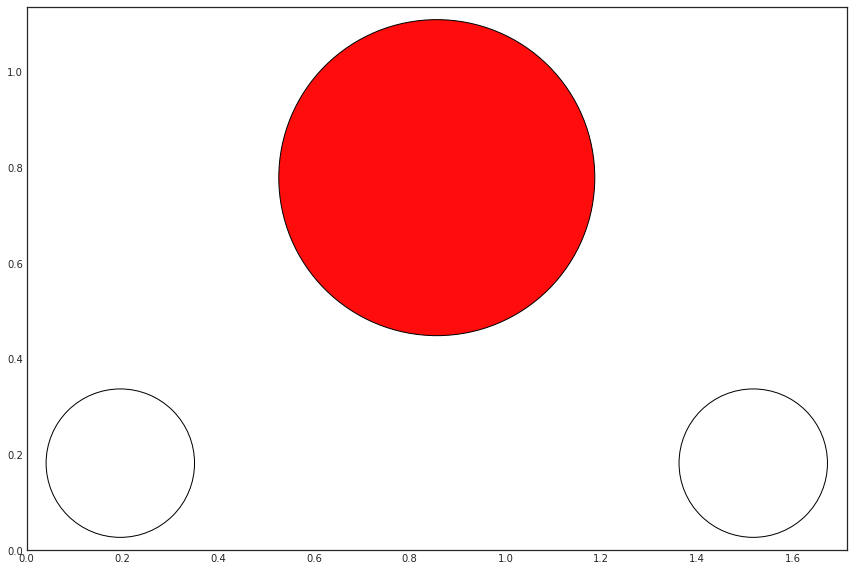

In [22]:
plt.figure(figsize=(18, 10))
plot_atoms(H2O, radii=0.5, rotation=('90x,60y,0z'), show_unit_cell=True)
#Fe_bcc111_l40_aq.write(sim_path + "fe_aq/Fe_bcc111_l40_aq.extxyz")
plt.show()

In [23]:
aq_efields = np.arange(0.0, 2.1, 0.1) # V/A = 100MV/cm => 0 MV/cm to 45 MV/cm
aq_efields_names = ['Aq_efield_{0:.0f}MVcm'.format(x*100) for x in aq_efields]
aq_efields_names

['Aq_efield_0MVcm',
 'Aq_efield_10MVcm',
 'Aq_efield_20MVcm',
 'Aq_efield_30MVcm',
 'Aq_efield_40MVcm',
 'Aq_efield_50MVcm',
 'Aq_efield_60MVcm',
 'Aq_efield_70MVcm',
 'Aq_efield_80MVcm',
 'Aq_efield_90MVcm',
 'Aq_efield_100MVcm',
 'Aq_efield_110MVcm',
 'Aq_efield_120MVcm',
 'Aq_efield_130MVcm',
 'Aq_efield_140MVcm',
 'Aq_efield_150MVcm',
 'Aq_efield_160MVcm',
 'Aq_efield_170MVcm',
 'Aq_efield_180MVcm',
 'Aq_efield_190MVcm',
 'Aq_efield_200MVcm']

In [41]:
for sim, efield in zip(aq_efields_names, aq_efields):
    calc = reaxff_params_generator(H2O, 
                                   job_name=sim,
                                   write_input=True,
                                   input_fd=aq_dir,
                                   pair_style= "reax/c NULL safezone 16 efield 0.0 0.0 {:.2f} -1.0 13.0 -1.0 13.0 -1.0 13.0".format(efield),
                                   minimize="1.0e-30 1.0e-30 100 1000",
                                   run=2,
                                   timestep=0.1,
                                   dump_period=1,
                                   fix=["qeq_reaxc all qeq/reax 1 0.0 10.0 1e-10 reax/c dual",
                                        "elec all efield 0.0 0.0 {:.1f}".format(efield),
                                        "reax_info all reax/c/bonds 1 bonds.tatb"],
                                   potential=potential)

In [42]:
aq_commands = [["mpiexec /rds/general/user/yx6015/home/lammps/build/lmp -sf omp -pk omp 1 -in {0}.lammpsin".format(x)] for x in aq_efields_names]
aq_source_files = [['$HOME/LAMMPS_Simulation/potentials/{0}'.format(potential),
                    '$PBS_O_WORKDIR/{}.*'.format(x)] for x in aq_efields_names]

aq_PBS = PBS_Submitter(job_names=aq_efields_names,
                       job_commands=aq_commands,
                       modules=["mpi/intel-2018", "intel-suite/2017.6"],
                       walltime="1:00:00",
                       proc_nodes=1,
                       proc_cpus=1,
                       proc_mpiprocs=1,
                       proc_threads=1,
                       memory=2,
                       source_files=aq_source_files)

In [ ]:
os.chdir(aq_dir)
aq_out, aq_err = aq_PBS.run()
os.chdir(sim_path)
print(aq_out, aq_efields_names)

In [44]:
# Move all the log and error files over

for outfile, job_out in zip(aq_efields_names, aq_out):
    shutil.move(os.path.join(aq_dir, outfile + ".err"), os.path.join(ephemeral, job_out))
    shutil.move(os.path.join(aq_dir, outfile + ".log"), os.path.join(ephemeral, job_out))

In [3]:
all_charge_dist = dict()

for outfile, job_out in zip(aq_efields_names, aq_out):
    f_path = os.path.join(ephemeral, job_out, "bonds.tatb")
    charge_dist = []
    
    with open(f_path) as f:
        for line in f:
            if line.startswith('#'):
                continue
            else:
                line_split = line.split()
                charge_dist.append([int(line_split[0]), int(line_split[1]), float(line_split[-1])])
    all_charge_dist[outfile] = np.array(charge_dist)

In [4]:
all_charge = []
for name in aq_efields_names:
    d = all_charge_dist[name]

    all_charge.append([int(name.split('_')[-1].split('M')[0]), d[0, 2], d[1:2, 2].mean()])
all_charge = np.array(all_charge)

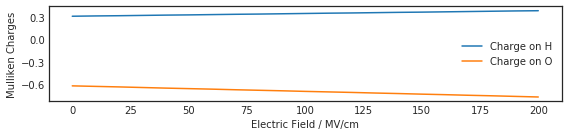

In [13]:
plt.style.use("seaborn-white")
f = plt.figure(figsize=(8, 2))
x_axis = all_charge[:, 0]
plt.plot(x_axis, all_charge[:, 2], label = 'Charge on H')
plt.plot(x_axis, all_charge[:, 1], label = 'Charge on O')
plt.yticks([-0.6, -0.3, 0, 0.3])
plt.xlabel('Electric Field / MV/cm')
plt.ylabel('Mulliken Charges')
plt.legend()

f.tight_layout()
f.savefig('water_charges.eps', dpi=400, bbox_inches="tight")

plt.show()